# Bayes Nets
** A Julia package for Bayesian Networks **

A Bayesian Network (BN) represents a probability distribution over a set of variables, $P(x_1, x_2, \ldots, x_n)$. They leverage variable relations in order to efficiently decompose the joint distribution into smaller conditional probability distributions.

A BN is defined by a directed acyclic graph and a set of conditional probability distributions. Each node in the graph corresponds to a variable $x_i$ and is associated with a conditional probability distribution $P(x_i \mid \text{parents}(x_i))$.

## Installation

In [1]:
Pkg.add("BayesNets");

Visualization of network structure is provided by the TikzGraphs package. Installation requirements (e.g., PGF/Tikz and pdf2svg) are provided [here](http://nbviewer.ipython.org/github/sisl/TikzGraphs.jl/blob/master/doc/TikzGraphs.ipynb).

## Use

In [1]:
srand(0) # seed the random number generator to 0, for a reproducible demonstration
using BayesNets

## Representation

Bayesian Networks are represented with the `BayesNet` type. This type contains the directed acyclic graph (a LightTables.DiGraph) and a list of conditional probability distributions (a list of CPDs)

Here we construct the BayesNet $a \rightarrow b$, with Gaussians $a$ and $b$:

$$
a = \mathcal{N}(0,1) \qquad b = \mathcal{N}(2a +1,1)
$$

In [2]:
bn = BayesNet()
push!(bn, CPD(:a, Normal(0.0,1.0), StaticCPD()))
push!(bn, CPD(:b, [:a], Normal(0.0,1.0), LinearGaussianCPD([2.0], 1.0)))

## Conditional Probability Distributions

Conditional Probablity Distributions, $P(x_i \mid \text{parents}(x_i))$, are defined in BayesNets.CPDs. Each CPD knows its own name, the names of its parents, and is associated with a distribution from Distributions.jl.

Each CPD also has a `CPDForm`. This defines how the CPD is learned and updated given its parents.

| `CPDForm`           | Description |
| ------------------- | ----------- |
| `StaticCPD`         | Any `Distributions.distribution`, indepedent of any parents |
| `CategoricalCPD`    | Categorical distribution, assumes integer target and parents in $1:N$ |
| `LinearGaussianCPD` | Linear Gaussian, assumes target and parents are numeric |

Each CPD can be learned from data using `fit`.

Here we learn the same network as above.

In [3]:
a = randn(100)
b = randn(100) .+ 2*a .+ 1

data = DataFrame(a=a, b=b)
cpdA = fit(CPD{Normal, StaticCPD}, data, :a)
cpdB = fit(CPD{Normal{Float64}, LinearGaussianCPD}, data, :b, [:a])

bn2 = BayesNet([cpdA, cpdB])

Each `CPD` implements a set of core functionality, allowing for obtaining the target name `name(cpd)`, the parents `parents(cpd)`, etc.

Calling `distribution(cpd)` will give you the _current_ form of the CPD's internal distribution.

In [4]:
distribution(cpdB)

Distributions.Normal{Float64}(μ=NaN, σ=2.2361096378352023)

The CPD must be set from an assignment using `condition!`:



In [5]:
condition!(cpdB, Assignment(:a=>1.0))

Distributions.Normal{Float64}(μ=2.717172074065112, σ=2.2361096378352023)

Several functions conveniently condition and then produce their return values

In [6]:
rand!(cpdB, Assignment(:a=>1.0)) # condition and then sample
pdf!(cpdB, Assignment(:a=>1.0, :b=>3.0)) # condition and then compute pdf(distribution, 3)
logpdf!(cpdB, Assignment(:a=>1.0, :b=>3.0)) # condition and then compute logpdf(distribution, 3);

## Likelihood 

A Bayesian Network represents a joint probability distribution, $P(x_1, x_2, \ldots, x_n)$. 
Assignments are represented as dictionaries mapping variable names (Symbols) to variable values.
We can evaluate probabilities as we would with Distributions.jl, only we use exclamation points as we modify the internal state when we condition:

In [7]:
pdf!(bn, Assignment(:a=>0.5, :b=>2.0)) # evaluate the probability density

0.1404537443096252

We can also evaluate the likelihood of a dataset

In [8]:
data = DataFrame(a=[0.5,1.0,2.0], b=[2.0,3.0,5.0])
pdf!(bn, data)    #  0.000292
logpdf!(bn, data) # -8.138631;

## Sampling

Assignments can be sampled from a `BayesNet`.

In [9]:
rand(bn)

Dict{Symbol,Any} with 2 entries:
  :a => 0.06467678861102817
  :b => 2.0369902749018216

In [10]:
rand(bn, 5)

,a,b
1,0.7208393833885718,1.755114617840761
2,-0.23769600340388383,-0.5082776994852769
3,-1.800550173390088,-3.765562352742042
4,1.2115810954933637,3.5158655210501832
5,-1.273598490270002,-0.28660356660207764


## Parameter Learning

BayesNets.jl supports parameter learning for an entire graph.

In [11]:
dag = DAG(2)
add_edge!(dag, 1, 2)
fit(BayesNet, data, dag, [CPD{Normal, StaticCPD}, CPD{Normal{Float64}, LinearGaussianCPD}]) # specify each node's CPD type individually

In [12]:
fit(BayesNet, data, dag, CPD{Normal{Float64}, LinearGaussianCPD}) # specify a single CPD type for all nodes

Fitting can be done for specific BayesNets types as well:

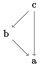

In [13]:
data = DataFrame(c=[1,1,1,1,2,2,2,2,3,3,3,3], 
                 b=[1,1,1,2,2,2,2,1,1,2,1,1],
                 a=[1,1,1,2,1,1,2,1,1,2,1,1])

dag = DAG(3)
add_edge!(dag, 1, 2)
add_edge!(dag, 1, 3)
add_edge!(dag, 2, 3)

fit(DiscreteBayesNet, data, dag)

## Structure Learning

Structure learning can be done as well.

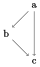

In [14]:
cache = ScoreComponentCache(data)
params = BayesNets.GreedyHillClimbing(cache, max_n_parents=3, prior=UniformPrior())
bn = fit(DiscreteBayesNet, data, params)

A whole suite of features are supported for DiscreteBayesNets.

In [15]:
bayesian_score(bn, data, params.prior) # compute the Bayesian score of the data under the BayesNet

-31.28804624550449

In [16]:
count(bn, :a, data) # obtain a list of counts for the node

,a,count
1,1,9
2,2,3


In [17]:
statistics(bn.dag, data) # sufficient statistics from a discrete dataset

3-element Array{Array{Int64,2},1}:
 3x1 Array{Int64,2}:
 4
 4
 4                           
 2x3 Array{Int64,2}:
 3  1  3
 1  3  1                  
 2x6 Array{Int64,2}:
 3  1  3  0  2  0
 0  0  0  1  1  1

In [18]:
table(bn, :b) # obtain the factor table for a node

,a,b,p
1,1,1,0.7777777777777778
2,2,1,0.0
3,1,2,0.2222222222222222
4,2,2,1.0


In [19]:
table(bn, :c, Assignment(:a=>1)) # obtain a factor table matching a particular assignment

,b,a,c,p
1,1,1,1,0.42857142857142855
2,2,1,1,0.0
3,1,1,2,0.14285714285714285
4,2,1,2,1.0
5,1,1,3,0.42857142857142855
6,2,1,3,0.0
